In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import os

import sklearn.linear_model as linear_models
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
from statsmodels.tsa.stattools import acf 
from statsmodels.stats.diagnostic import het_breuschpagan


In [23]:
# load your dataset
data_dir = os.path.join(os.getcwd(), 'data_files')

target_df = pd.read_csv(os.path.join(data_dir, 'targets.csv'), parse_dates=['USAGE_DATE'], index_col='USAGE_DATE')
predictor_df = pd.read_csv(os.path.join(data_dir, 'predictors.csv'), parse_dates=['USAGE_DATE'], index_col='USAGE_DATE')
predictor_df['Holiday'] = predictor_df['Holiday'].astype(int)

df = target_df.join(predictor_df)
df = df.sort_index(ascending=False)
df.dropna(inplace=True)

In [24]:
target_df

,SoCal_TOTAL,SoCal_RES,SoCal_IND,SoCal_COM,SoCal_CUST_COUNT,SD_TOTAL,SD_NON,SD_RES,SD_CUST_COUNT,SEU_TOTAL,SEU_CUST_COUNT
USAGE_DATE,,,,,,,,,,,
2021-05-31,648.895908,479.657939,24.637510,144.600459,5962844.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-30,631.813202,467.817417,20.055766,143.940020,5961998.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-29,671.912697,479.006387,28.428651,164.477659,5964487.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-28,682.146302,441.580027,54.389126,186.177149,5964370.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-27,669.499428,425.906469,61.866068,181.726891,5964182.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2016-05-05,727.331274,485.026260,57.266377,185.038637,5903778.0,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-04,692.490619,456.040119,57.061394,179.389106,5901834.0,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-03,674.673874,444.042548,56.557142,174.074185,5903069.0,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
len(predictors)

1518


## assuming data exploration is complete, we go next to model building

In [25]:
def linear_evaluation(predictors, target): 
    lm = linear_models.LinearRegression()

    # cross-validation model analyses
    scoring = ['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'explained_variance']
    lm_scores = cross_validate(lm, predictors, target, cv=5, scoring=scoring)

    # post-hoc model analyses using full dataset
    lm.fit(predictors, target)
    T = len(predictors) # of samples
    k = len(lm.coef_) # number of predictors
    residuals = lm.predict(predictors) - target
    SSE = np.sum(residuals.values**2)
    
    AIC = T * np.log(SSE/T) + (2 * (k+2))
    AICc = AIC + ((2*(k+2)*(k+3)) / (T-k-3))
    BIC = T * np.log(SSE/T) + (k+2) * np.log(T)
    r2_adj = 1 - (1-np.mean(lm_scores['test_r2']))*((T-1)/(T-k-1))

    analyses = dict(zip(scoring, [np.mean(lm_scores['test_' + metric]) for metric in scoring]))
    post_hoc = {'AIC': AIC, 'AIC bias corrected': AICc, 'BIC': BIC, 'r2 adjusted': r2_adj}
    analyses.update(post_hoc)

    analyses_df = pd.DataFrame.from_dict(analyses, orient='index').transpose()
    return lm, analyses_df

In [26]:
region = 'SoCal' # can be SD or SoCal
target = df[region + '_TOTAL']

predictor_dict = \
{'set_1': [region + '_HDD',region + '_t-1_HDD', region + '_t-2_HDD', region + '_t-3_HDD',
                 region + '_CDD',region + '_t-1_CDD', region + '_t-2_CDD', 
                 region+'_HDD_7', region + '_t-1_HDD_7', region + '_t-2_HDD_7',
               'Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec',
               'Sat','Sun','Holiday'],
'set_2': [region + '_HDD',region + '_t-1_HDD', region + '_t-2_HDD',
                 region + '_CDD',region + '_t-1_CDD', 
                 region+'_HDD_7', region + '_t-1_HDD_7', 
               'Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec',
               'Sat','Sun','Holiday'],
'set_3': [region + '_HDD',region + '_t-1_HDD', region + '_t-2_HDD', region + '_t-3_HDD',
                 region + '_CDD',region + '_t-1_CDD', region + '_t-2_CDD', 
                 region+'_HDD_7', region + '_t-1_HDD_7', region + '_t-2_HDD_7',
               'day_of_year_sine', 'day_of_year_cosine',
               'Sat','Sun','Holiday'],
'set_4': [region + '_HDD',region + '_t-1_HDD', region + '_t-2_HDD',
                 region + '_CDD',region + '_t-1_CDD',
                 region+'_HDD_7', region + '_t-1_HDD_7',
               'day_of_year_sine', 'day_of_year_cosine',
               'Sat','Sun','Holiday'],
'set_5': [region + '_HDD',region + '_t-1_HDD', region + '_t-2_HDD', region + '_t-3_HDD',
                 region + '_CDD',region + '_t-1_CDD', region + '_t-2_CDD', 
                 region+'_HDD_7', region + '_t-1_HDD_7', region + '_t-2_HDD_7',
               'month_sine', 'month_cosine',
               'Sat','Sun','Holiday'],
'set_6': [region + '_HDD',region + '_t-1_HDD', region + '_t-2_HDD',
                 region + '_CDD',region + '_t-1_CDD',
                 region+'_HDD_7', region + '_t-1_HDD_7',
               'month_sine', 'month_cosine',
               'Sat','Sun','Holiday'],
}

In [27]:
#selecting optimal number of features
evaluation_df = pd.DataFrame()
for key, value in predictor_dict.items(): 
    lm, tmp_df = linear_evaluation(df[value], target)
    tmp_df.index = [key]
    evaluation_df = pd.concat([evaluation_df, tmp_df])
    
evaluation_df

,r2,neg_mean_absolute_error,neg_mean_squared_error,explained_variance,AIC,AIC bias corrected,BIC,r2 adjusted
set_1,0.975907,-37.083926,-3150.306678,0.977928,12014.868449,12015.883214,12158.647470,0.975503
set_2,0.975010,-38.028996,-3264.528734,0.977250,12064.266998,12065.070749,12192.070573,0.974642
set_3,0.971599,-42.425237,-3648.542100,0.972615,12328.385084,12328.793084,12418.912616,0.971316
set_4,0.970308,-43.866409,-3819.067438,0.971488,12397.316463,12397.595904,12471.868549,0.970072
set_5,0.969135,-44.005490,-3948.354475,0.969865,12464.423107,12464.831107,12554.950639,0.968827
set_6,0.967479,-45.869915,-4165.475070,0.968336,12545.631793,12545.911234,12620.183878,0.967219


In [19]:
def check_residuals(residual_df, predictors_df, nlags=21):
    """
    :param residual_df. dataframe that contains (1).index as time (2)['residuals'] as residuals
    """
    fig = plt.figure(figsize=(12,6))
    gs = GridSpec(2, 2, figure=fig)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])

    sns.lineplot(x=residual_df.index, y='residuals', data=residual_df, ax=ax1)
    sns.barplot(x=np.arange(0, nlags+1), y=acf(residual_df['residuals'], fft=False, nlags=nlags), ax=ax2)
    ax2.set_xlabel('lag'), ax2.set_ylabel('autocorrelation'), ax2.set_xticks(np.arange(0, nlags, 100)),
    ax2.set_xticklabels(np.arange(0, nlags, 100))
    sns.histplot(residual_df, ax=ax3)
    ax3.set_xlabel('residuals'), 
    plt.tight_layout(), plt.show()
    
    bp_test = het_breuschpagan(residual_df.iloc[:nlags]['residuals'], predictors_df.iloc[:nlags,:])
    labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
    print(dict(zip(labels, bp_test)))
    
    if bp_test[1] > 0.05:
        print('WARNING: heteroscedasity detected. Residuals are not evenly distributed.')
    

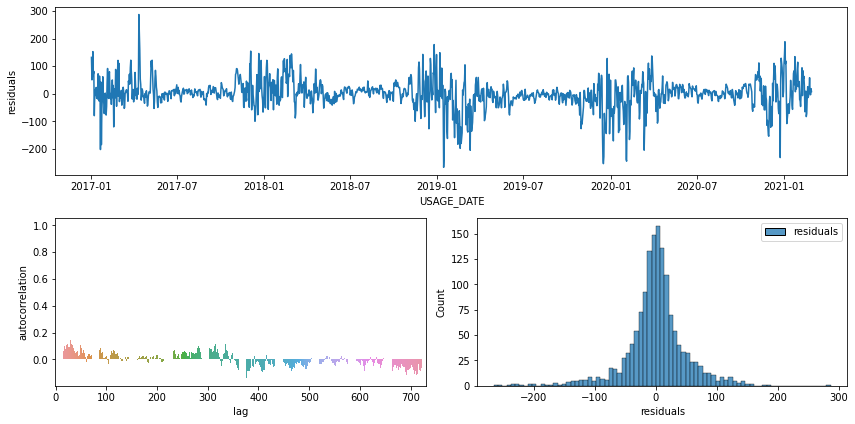

{'LM Statistic': 151.35247274437165, 'LM-Test p-value': 1.8566941331662137e-20, 'F-Statistic': 7.683397366185969, 'F-Test p-value': 2.919605691743595e-23}


In [ ]:
lm = linear_models.LinearRegression()
predictors = df[predictor_dict['set_1']]
lm.fit(predictors, target)
residual_df = pd.DataFrame(lm.predict(predictors) - target)
residual_df.columns = ['residuals']

# h=10 for non-seasonal data and h=2m for seasonal data, where m is the period of seasonality
check_residuals(residual_df, predictors, nlags=730)